<a href="https://www.kaggle.com/tuankiennguyen/brain-segmentation-with-pytorch?scriptVersionId=88447866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [2]:
pip install torchio

     |████████████████████████████████| 164 kB 621 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import time
import tqdm
import os
import argparse
import logging
import sys
import wandb
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

import nibabel as nib
import torchio as tio
import tempfile

import torch
import torch.nn as nn
from torch.nn.functional import pad, sigmoid, binary_cross_entropy
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
    
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import sklearn 
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import clear_output
%matplotlib inline

# **Visualize Data Image**

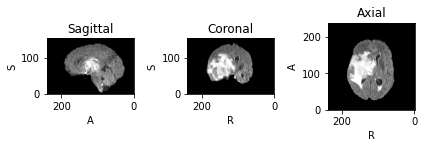

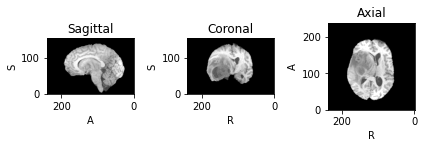

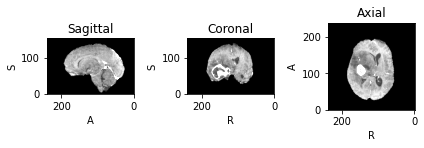

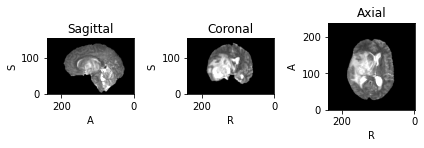

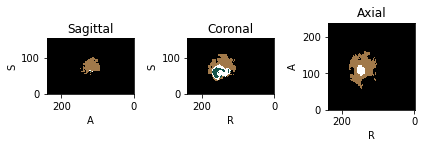

In [5]:
flair_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
t1_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
t1ce_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
t2_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
seg_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'


flair_img = tio.ScalarImage(flair_path)
t1_img = tio.ScalarImage(t1_path)
t1ce_img = tio.ScalarImage(t1ce_path)
t2_img = tio.ScalarImage(t2_path)
seg_img = tio.LabelMap(seg_path)

flair_img.plot()
t1_img.plot()
t1ce_img.plot()
t2_img.plot()
seg_img.plot()

# **Preprocess Dataset and Clean Data**

In [6]:
"""
Create class function for target path and seed random
"""
class GlobalConfig():
    root = '../input/brats20-dataset-training-validation/'
    train_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    val_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    name_mapping_path = 'name_mapping.csv'
    survival_info_path = 'survival_info.csv'
    train_df = 'train_df.csv'
    seed = 55
def SeedEveryThing(seed:int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = GlobalConfig()
SeedEveryThing(config.seed)

In [7]:
"""
In this dataset of MICCAI_BraTS2020, it has two data files CSV so we need to
merge them into one data frame to visualize and remove null data 
"""

name_mapping = pd.read_csv(os.path.join(config.root, config.train_path + config.name_mapping_path))
survival_info = pd.read_csv(os.path.join(config.root, config.train_path + config.survival_info_path))
name_mapping.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis = 1, inplace = True)
df = survival_info.merge(name_mapping, on='Brats20ID', how='right')
path = []
for _, row in df.iterrows():
    id_ = row['Brats20ID']
    phase = id_.split('_')[-2]
    if phase == 'Training':
        data_path = os.path.join(config.root, config.train_path + id_)
    else:
        data_path = os.path.join(config.root, config.train_path + id_)
    path.append(data_path)
df['Path'] = path
df['Age_rank'] = df['Age'].values//10*10
df= df.loc[df['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop = True)
train_df = df.loc[df['Age'].isnull() != True].reset_index(drop = True)
skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle = True)
for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df['Age_rank'])):
    train_df.loc[val_index,['Fold']] = i
train_data = train_df.loc[train_df['Fold'] != 0.0].reset_index(drop=True)
val_data = train_df.loc[train_df['Fold'] == 0.0].reset_index(drop=True)
test_df = df.loc[df['Age'].isnull()].reset_index(drop=True)
train_df.to_csv(config.train_df, index = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brats20ID              368 non-null    object 
 1   Age                    235 non-null    float64
 2   Survival_days          235 non-null    object 
 3   Extent_of_Resection    128 non-null    object 
 4   Grade                  368 non-null    object 
 5   BraTS_2017_subject_ID  285 non-null    object 
 6   BraTS_2018_subject_ID  285 non-null    object 
 7   TCGA_TCIA_subject_ID   167 non-null    object 
 8   BraTS_2019_subject_ID  335 non-null    object 
 9   Path                   368 non-null    object 
 10  Age_rank               235 non-null    float64
dtypes: float64(2), object(9)
memory usage: 31.8+ KB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in floor_divide
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)


In [8]:
# List transform
def get_transform(phase):
    if phase == 'train':
        # As RandomAffine is faster then RandomElasticDeformation, we choose to
        # apply RandomAffine 80% of the times and RandomElasticDeformation the rest
        # Also, there is a 25% chance that none of them will be applied
        list_transforms = [
            tio.RandomAffine(p = 0.5),
            tio.RandomFlip(axes=['LR', 'AP', 'IS'], p = 0.25),
            tio.RandomBiasField(p = 0.25),
            tio.RandomBlur(p = 0.25),
            tio.RandomNoise(p = 0.25),
            
        ]
        # Transforms can be composed as in torchvision.transforms
        transform = tio.Compose(list_transforms)
    else:
        list_transforms = []
        transform = tio.Compose(list_transforms)
    return transform

# **Create Brats Dataset function**

In [9]:
# class BratsDataSet(Dataset):
#     def __init__(self, df: pd.DataFrame, phase: str = 'test'):
#         self.df = df
#         self.phase = phase
#         self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
#         self.augmentaions = get_augmentaions(phase)
#     def __len__(self):
#         return self.df.shape[0]
#     def __getitem__(self, index):
#         id_ = self.df.loc[index, 'Brats20ID']
#         data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
#         data_img = []
#         for data_type in self.data_types:
#             data = nib.load(os.path.join(data_path,id_ + data_type)) #data_img shape (1, 240, 240, 155)
#             img = np.asarray(data.dataobj)
# #             img = img.transpose(2,0,1)
#             img = self.Resize(img)
#             img = self.Normalize(img)
#             data_img.append(img)
#         image_stack = np.stack(data_img) # data shape = [4, 72, 72, 72]
#         image_stack = np.moveaxis(image_stack, (0,1,2,3), (0,3,2,1))
#         if phase != 'test':
#             data_label = nib.load(os.path.join(data_path, id_ + '_seg.nii'))
#             label = np.asarray(data_label.dataobj)
#             label = self.Resize(label)
#             label_stack = self.ConvertToMultiChannel(label)
#             augmented = self.augmentaions(image = image_stack.astype(np.float32), mask = label_stack.astype(np.float32))
            
#             img = augmented['image']
#             label = augmented['mask']
            
#             return {
#                 'ID': id_,
#                 'image':img,
#                 'label':label
#             }
#         return{
#             'ID': id_,
#             'image': img
#         }
#     def Resize(self, img : np.ndarray):
#         img = resize(img, (120,120,72), preserve_range = True)
#         return img
        
#     def Normalize(self, image : np.ndarray):
#         return (image - np.min(image))/(np.max(image) - np.min(image))
                
#     def ConvertToMultiChannel(self, label):
#         '''
#         Convert labels to multi channels based on brats classes:
#         label 1 is the peritumoral edema
#         label 2 is the GD-enhancing tumor
#         label 3 is the necrotic and non-enhancing tumor core
#         The possible classes are TC (Tumor core), WT (Whole tumor)
#         and ET (Enhancing tumor)
#         '''
#         label_TC = label.copy()
#         label_TC[label_TC == 1] = 1
#         label_TC[label_TC == 2] = 0
#         label_TC[label_TC == 4] = 1
# #         label_TC = np.clip(label_TC.astype(np.uint8), 0, 1). astype(np.float32)
# #         label_TC = np.clip(label_TC, 0, 1)
        
        
#         label_WT = label.copy()
#         label_WT[label_WT == 1] = 1
#         label_WT[label_WT == 2] = 1
#         label_WT[label_WT == 4] = 1
        
#         label_ET = label.copy()
#         label_ET[label_ET == 1] = 0
#         label_ET[label_ET == 2] = 0
#         label_ET[label_ET == 4] = 1
        
#         label_stack = np.stack([label_WT, label_TC, label_ET])
#         label_stack = np.moveaxis(label_stack, (0,1,2,3), (0,3,2,1))
#         return label_stack
    
# def get_augmentaions(phase):
#     list_transforms = []
    
#     list_trfms = A.Compose(list_transforms)
#     return list_trfms

In [10]:
class BratsDataSet(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = 'test'):
        self.df = df
        self.phase = phase
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        id_ = self.df.loc[index, 'Brats20ID']
        data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
        data_img = []
        resample = tio.Resample((2,2,2))
#         normalize = tio.ZNormalization()
        for data_type in self.data_types:
            img = tio.ScalarImage(os.path.join(data_path, id_ + data_type)) #data_img shape (1, 240, 240, 155)
            img = resample(img) #data_img shape (1, 120, 120, 78)
#             img = normalize(img)
            img = np.array(img)
            img = np.squeeze(img, axis = 0)
            img = self.Normalize(img)
            data_img.append(img)
        img_stack = np.stack(data_img)
        img_stack = np.moveaxis(img_stack, (0,1,2,3), (0,3,2,1))
        img_stack = torch.Tensor(img_stack)
        
        if phase != 'test':
            labels = tio.LabelMap(os.path.join(data_path, id_ + '_seg.nii'))
            labels = resample(labels)
            labels = np.array(labels)
            labels = np.squeeze(labels, axis = 0)
            label_stack = self.ConvertToMultiChannel(labels)
            label_stack = torch.Tensor(label_stack)
            
            subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                                   label = tio.LabelMap(tensor = (label_stack > 0.5)),
                                   id = id_
                                  )
            
            
            return subjects
        subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                               id = id_
                              )
        return subjects
    
    def Normalize(self, image : np.ndarray):
        return (image - np.min(image))/(np.max(image) - np.min(image))
 
    def ConvertToMultiChannel(self, labels):
        '''
        Convert labels to multi channels based on brats classes:
        label 1 is the peritumoral edema
        label 2 is the GD-enhancing tumor
        label 3 is the necrotic and non-enhancing tumor core
        The possible classes are TC (Tumor core), WT (Whole tumor)
        and ET (Enhancing tumor)
        '''
        label_TC = labels.copy()
        label_TC[label_TC == 1] = 1
        label_TC[label_TC == 2] = 0
        label_TC[label_TC == 4] = 1
        
        
        label_WT = labels.copy()
        label_WT[label_WT == 1] = 1
        label_WT[label_WT == 2] = 1
        label_WT[label_WT == 4] = 1
        
        label_ET = labels.copy()
        label_ET[label_ET == 1] = 0
        label_ET[label_ET == 2] = 0
        label_ET[label_ET == 4] = 1
        
        label_stack = np.stack([label_WT, label_TC, label_ET])
        label_stack = np.moveaxis(label_stack, (0,1,2,3), (0,3,2,1))
        return label_stack
        

In [11]:
def get_dataloader(dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4):
    """
    This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
    to split and transform image
    """
    start_time = time.time()
    data = pd.read_csv(path_to_csv)
    train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
    val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    for i in range(len(data_set)):
        list_subjects.append(data_set[i])
    subject_dataset = tio.SubjectsDataset(list_subjects, transform=get_transform(phase))
    patch_size = 50
    queue_length = 300
    sample_per_volume = 1
    sampler = tio.data.UniformSampler(patch_size)
    patches_queue = tio.Queue(
        subject_dataset,
        queue_length,
        sample_per_volume,
        sampler,
        num_workers=num_workers,
    )
    data_loader = DataLoader(patches_queue,
                             batch_size = batch_size,
                             num_workers=0,
                             pin_memory=True,
                            )
    return data_loader

In [12]:
# dataloader = get_dataloader(dataset=BratsDataSet, path_to_csv=config.train_df, phase='valid', fold=0)
# len(dataloader)

# Check Data - 1

In [13]:
# data = next(iter(dataloader))
# data['id'], data['image'][tio.DATA].shape, data['label'][tio.DATA].shape

In [14]:
# img_tensor = data['image'][tio.DATA].squeeze()[3].cpu().detach().numpy() 
# mask_tensor = data['label'][tio.DATA].squeeze()[1].squeeze().cpu().detach().numpy()
# image = np.rot90(montage(img_tensor))
# mask = np.rot90(montage(mask_tensor)) 

# fig, ax = plt.subplots(1, 1, figsize = (20, 20))
# ax.imshow(image, cmap ='bone')
# ax.imshow(np.ma.masked_where(mask == False, mask),
#            cmap='cool', alpha=0.6)

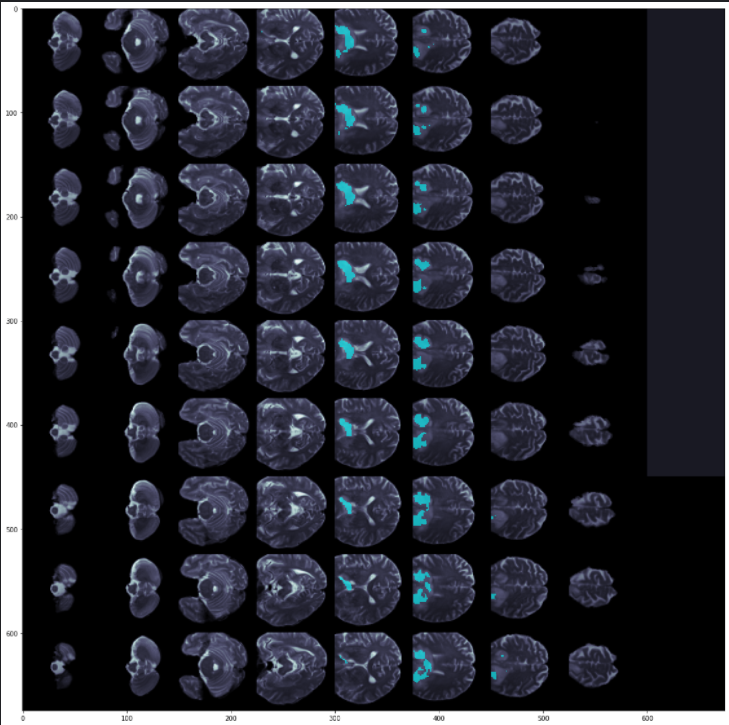

# **Dice Loss**

The Dice coefficient, or Dice-Sørensen coefficient, is a common metric for pixel segmentation that can also be modified to act as a loss function:

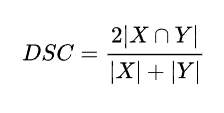


In [15]:
class DiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # Commnent out if your model contains a sigmoid or equivalent activation layer
        inputs = sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum()+ targets.sum() + smooth)
        return 1 - dice

In [16]:
def dice_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps:float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch,
    Params:
        inputs: model outputs after activation function
        target: true values
        threshold: threshold for inputs
        eps: additive to refine the estimate
    Return: dice score 
    """
    score = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        predict = predictions[i]
        target_ = target[i]
        intersection = 2.0*(target_*predict).sum()
        union = target_.sum() + predict.sum()
        if target_.sum() == 0 and predict.sum() == 0:
            score.append(1.0)
        else:
            score.append((intersection + eps)/union)
    return np.mean(score)

In [17]:
def dice_coef_metric_class(inputs, targets, threshold=0.5, eps:float=1e-9,classes = ['WT, TC', 'ET']):
    """ calculate dice scores for each class"""
    scores = {key:list for key in classes}
    num = inputs.shape[0]
    num_classes = inputs.shape[1]
    predictions = (inputs>=threshold).astype(np.float32)
    assert(prediction.shape == target.shape)
    for i in range(num):
        for class_ in classes:
            prediction = predictions[i][class_]
            target_ = target[i][class_]
            intersection = 2.0 * (prediction * prediction).sum()
            union = target_.sum() + prediction.sum()
            if target.sum() == 0 and prediction.sum() == 0:
                scores[classes][class_].append(1.0)
            else:
                scores[classes][class_].append((intersection+eps)/(union))
    return scores

# **Jaccard/Intersection over Union (IoU) Loss**

The IoU metric, or Jaccard Index, is similar to the Dice metric and is calculated as the ratio between the overlap of the positive instances between two sets, and their mutual combined values:

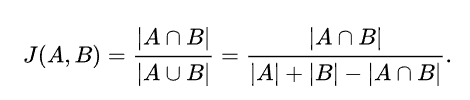

Like the Dice metric, it is a common means of evaluating the performance of pixel segmentation models.


In [18]:
class IoU(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(IoU, self).__init__()
    def forward(self, inputs, target, smooth = 1):
        inputs = sigmoid(inputs)
        
        # Flatten labels and predict
        inputs = inputs.view(-1)
        target = target.view(-1)
        
        interection = (inputs*target).sum()
        total = (inputs + target).sum()
        union = total - interection
        
        IoU = (interection + smooth)/ (union + smooth)
        return 1 - IoU

In [19]:
def jaccard_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps: float = 1e-9):
    scores = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        prediction = predictions[i]
        target_ = target[i]
        intersection = (prediction * target_).sum()
        union = (prediction.sum() + target_.sum()) - (intersection + eps)
        
        if target_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps)/union)
    return np.mean(scores)

In [20]:
def jarccard_coef_classes(inputs, target, theshold:float = 0.5, eps: float = (1e-9), classes = ['WT', 'TC', 'ET']):
    scores = []
    num = inputs.shape[1]
    predictions = (inputs >= threshold).astype(np.float32)
    for i in range(num):
        for class_ in classes:
            prediction = predictions[i][class_]
            target_ = target[i][class_]
            intersection = (prediction*target_).sum()
            union = (target_.sum() + prediction.sum()) - intersection
            assert(prediction.sum() == target_.sum())
            
            if prediction.sum() == 0 and target_.sum() == 0:
                scores[classes][class_].append(1.0)
            else:
                scores[classes][class_].append((intersection+eps)/uniom)
    return scores

# **BCE-Dice Loss**

This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. Combining the two methods allows for some diversity in the loss, while benefitting from the stability of BCE. The equation for multi-class BCE by itself will be familiar to anyone who has studied logistic regression:

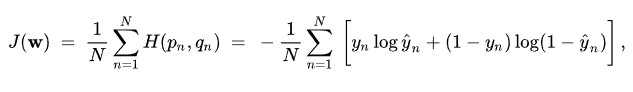

In [21]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets, smooth = 1):
        assert(inputs.shape == targets.shape)
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return  dice_loss + bce_loss
    

In [22]:
class Scores:
    def __init__(self, threshold: float=0.5):
        self.threshold = threshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    def update(self, logits: torch.Tensor, target: torch.Tensor):
        inputs = torch.sigmoid(logits)
        dice = dice_coef_metric(inputs, target, self.threshold)
        iou = jaccard_coef_metric(inputs, target, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    def get_metrics(self):
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

# **UNET 3D**

In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x

In [24]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [25]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [26]:
class UpP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*3, out_channels)
    def forward(self, x1, x2, x3):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x3.size()[4] - x1.size()[4]
        diffY1 = x3.size()[3] - x1.size()[3]
        diffZ1 = x3.size()[2] - x1.size()[2]
        
        diffX2 = x3.size()[4] - x2.size()[4]
        diffY2 = x3.size()[3] - x2.size()[3]
        diffZ2 = x3.size()[2] - x2.size()[2]
        
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x3, x2, x1], dim=1)
        return self.conv(x)

In [27]:
class UpPP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*4, out_channels)
    def forward(self, x1, x2, x3, x4):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x4.size()[4] - x1.size()[4]
        diffY1 = x4.size()[3] - x1.size()[3]
        diffZ1 = x4.size()[2] - x1.size()[2]
        
        diffX2 = x4.size()[4] - x2.size()[4]
        diffY2 = x4.size()[3] - x2.size()[3]
        diffZ2 = x4.size()[2] - x2.size()[2]
        
        diffX3 = x4.size()[4] - x3.size()[4]
        diffY3 = x4.size()[3] - x3.size()[3]
        diffZ3 = x4.size()[2] - x3.size()[2]
        
        x3 = torch.nn.functional.pad(x3, (diffX3 // 2, diffX3 - diffX3 // 2, diffY3 // 2, diffY3 - diffY3 // 2, diffZ3 // 2, diffZ3 - diffZ3 // 2))
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x4, x3, x2, x1], dim=1)
        return self.conv(x)

In [28]:
x1 = torch.empty([2, 512, 3, 3, 3])
x2 = torch.empty([2, 256, 6, 6, 6])
x3 = torch.empty([2, 256, 6, 6, 6])
x4 = torch.empty([2, 256, 6, 6, 6])
x5 = torch.empty([2, 256, 6, 6, 6])
up = UpPP(512, 256)
up(x1,x2,x3,x4).shape

torch.Size([2, 256, 6, 6, 6])

In [29]:
class UpPPP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*5, out_channels)
    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x5.size()[4] - x1.size()[4]
        diffY1 = x5.size()[3] - x1.size()[3]
        diffZ1 = x5.size()[2] - x1.size()[2]
        
        diffX2 = x5.size()[4] - x2.size()[4]
        diffY2 = x5.size()[3] - x2.size()[3]
        diffZ2 = x5.size()[2] - x2.size()[2]
        
        diffX3 = x5.size()[4] - x3.size()[4]
        diffY3 = x5.size()[3] - x3.size()[3]
        diffZ3 = x5.size()[2] - x3.size()[2]
        
        diffX4 = x5.size()[4] - x4.size()[4]
        diffY4 = x5.size()[3] - x4.size()[3]
        diffZ4 = x5.size()[2] - x4.size()[2]
        
        x4 = torch.nn.functional.pad(x4, (diffX4 // 2, diffX4 - diffX4 // 2, diffY4 // 2, diffY4 - diffY4 // 2, diffZ4 // 2, diffZ4 - diffZ4 // 2))        
        x3 = torch.nn.functional.pad(x3, (diffX3 // 2, diffX3 - diffX3 // 2, diffY3 // 2, diffY3 - diffY3 // 2, diffZ3 // 2, diffZ3 - diffZ3 // 2))
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x5, x4, x3, x2, x1], dim=1)
        return self.conv(x)

In [30]:
# if __name__ == '__main__':
#     up = Up(1024, 512)
#     tensor = torch.empty((1, 1024, 25, 25,25))
#     target = torch.empty((1,512,25,25,25))
#     test = up(tensor, target)
#     print(test.shape)

In [31]:
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)

In [32]:
'''
                            UNET 3D
        1|->|->|---------------------------->|->|->|1

              2|->|->|---------------->|->|->|2

                    3|->|->|---->|->|->|3     

                          4|->|->|4
'''
class UNET3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*16)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*8)
        self.up_3 = Up(self.out_channels*8, self.out_channels*4)
        self.up_2 = Up(self.out_channels*4, self.out_channels*2)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.5)
    def forward(self, x):
        # Encoder
        en_1 = self.double_conv(x)
#         en_1 = self.dropout(en_1)
        en_2 = self.down_1(en_1)
        en_2 = self.dropout(en_2)
        en_3 = self.down_2(en_2)
#         en_3 = self.dropout(en_3)
        en_4 = self.down_3(en_3)
        en_4 = self.dropout(en_4)
        en_5 = self.down_4(en_4)
#         en_5 = self.dropout(en_5)
        
        # Decoder
        de_4 = self.up_4(en_5, en_4)
        print(de_4.shape)
        de_4 = self.dropout(de_4)
        de_3 = self.up_3(de_4, en_3)
#         de_3 = self.dropout(de_3)
        de_2 = self.up_2(de_3, en_2)
        de_2 = self.dropout(de_2)
        de_1 = self.up_1(de_2, en_1)
#         de_1 = self.dropout(de_1)
        
        out = self.out(de_1)
        return out

In [33]:
model_1 = UNET3D(in_channels=4, out_channels=32, n_classes=3).to('cuda')
summary(model_1, (4, 50, 50, 50))

torch.Size([2, 256, 6, 6, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 50, 50, 50]           3,488
       BatchNorm3d-2       [-1, 32, 50, 50, 50]              64
              ReLU-3       [-1, 32, 50, 50, 50]               0
            Conv3d-4       [-1, 32, 50, 50, 50]          27,680
       BatchNorm3d-5       [-1, 32, 50, 50, 50]              64
              ReLU-6       [-1, 32, 50, 50, 50]               0
        DoubleConv-7       [-1, 32, 50, 50, 50]               0
         MaxPool3d-8       [-1, 32, 25, 25, 25]               0
            Conv3d-9       [-1, 64, 25, 25, 25]          55,360
      BatchNorm3d-10       [-1, 64, 25, 25, 25]             128
             ReLU-11       [-1, 64, 25, 25, 25]               0
           Conv3d-12       [-1, 64, 25, 25, 25]         110,656
      BatchNorm3d-13       [-1, 64, 25, 25, 25]             128
         

# UNET 3D ++

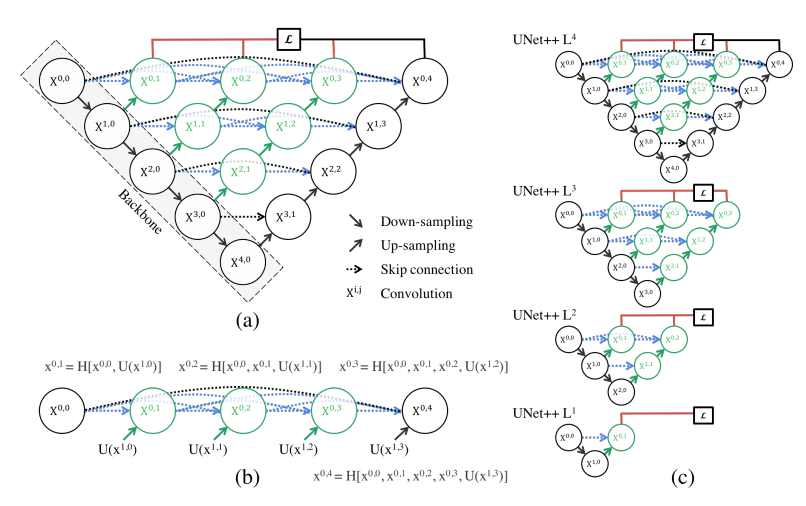

In [34]:
class UNET3DPP(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.x00 = DoubleConv(self.in_channels, self.out_channels)
        # UNet3D ++ L1
        self.down_to_x10 = Down(self.out_channels, self.out_channels*2)
        self.up_to_x01 = Up(self.out_channels*2, self.out_channels)
        # UNet3D ++ L2
        self.down_to_x20 = Down(self.out_channels*2, self.out_channels*4)
        self.up_to_x11 = Up(self.out_channels*4, self.out_channels*2)
        self.up_to_x02 = UpP(self.out_channels*2, self.out_channels)
        # UNet3D ++ L3
        self.down_to_x30 = Down(self.out_channels*4, self.out_channels*8)
        self.up_to_x21 = Up(self.out_channels*8, self.out_channels*4)
        self.up_to_x12 = UpP(self.out_channels*4, self.out_channels*2)
        self.up_to_x03 = UpPP(self.out_channels*2, self.out_channels)
        # UNet3D ++ L4
        self.down_to_x40 = Down(self.out_channels*8, self.out_channels*16)
        self.up_to_x31 = Up(self.out_channels*16, self.out_channels*8)
        self.up_to_x22 = UpP(self.out_channels*8, self.out_channels*4)
        self.up_to_x13 = UpPP(self.out_channels*4, self.out_channels*2)
        self.up_to_x04 = UpPPP(self.out_channels*2, self.out_channels)
        
        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.25)
    def forward(self, x):
        x00 = self.x00(x)
        # UNet3D ++ L1
        x10 = self.down_to_x10(x00)
        x01 = self.up_to_x01(x10, x00)
        x01 = self.dropout(x01)
        # UNet3D ++ L2
        x20 = self.down_to_x20(x10)
        x11 = self.up_to_x11(x20, x10)
        x11 = self.dropout(x11)
        x02 = self.up_to_x02(x11, x01, x00)
        x02 = self.dropout(x02)
        # UNet3D ++ L3
        x30 = self.down_to_x30(x20)
        x21 = self.up_to_x21(x30, x20)
        x21 = self.dropout(x21)
        x12 = self.up_to_x12(x21, x11, x10)
        x12 = self.dropout(x12)
        x03 = self.up_to_x03(x12, x02, x01, x00)
        x03 = self.dropout(x03)
        # UNet3D ++ L4
        x40 = self.down_to_x40(x30)
        x31 = self.up_to_x31(x40, x30)
        x31 = self.dropout(x31)
        x22 = self.up_to_x22(x31, x21, x20)
        x22 = self.dropout(x22)
        x13 = self.up_to_x13(x22, x12, x11, x10)
        x13 = self.dropout(x13)
        x04 = self.up_to_x04(x13, x03, x02, x01, x00)
        x04 = self.dropout(x04)
        
        # Output
        out = self.out(x04)
        return out

In [35]:
model_2 = UNET3DPP(in_channels=4, out_channels=32, n_classes=3).to('cuda')
summary(model_2, (4, 50, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 50, 50, 50]           3,488
       BatchNorm3d-2       [-1, 32, 50, 50, 50]              64
              ReLU-3       [-1, 32, 50, 50, 50]               0
            Conv3d-4       [-1, 32, 50, 50, 50]          27,680
       BatchNorm3d-5       [-1, 32, 50, 50, 50]              64
              ReLU-6       [-1, 32, 50, 50, 50]               0
        DoubleConv-7       [-1, 32, 50, 50, 50]               0
         MaxPool3d-8       [-1, 32, 25, 25, 25]               0
            Conv3d-9       [-1, 64, 25, 25, 25]          55,360
      BatchNorm3d-10       [-1, 64, 25, 25, 25]             128
             ReLU-11       [-1, 64, 25, 25, 25]               0
           Conv3d-12       [-1, 64, 25, 25, 25]         110,656
      BatchNorm3d-13       [-1, 64, 25, 25, 25]             128
             ReLU-14       [-1, 64, 25,

# **Training**

In [36]:
class Training:
    def __init__(self,
                 model: nn.Module,
                 dataset : Dataset,
                 criterion: nn.Module,
                 lr: float,
                 num_epochs: int,
                 batch_size: int,
                 path_to_csv: str,
                 fold: int,
                 accumulation_steps: int,
                 save_model_history: bool=True,
                 display_plot: bool= True
                ):
        # 1.Setup criterion and optimizer
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
        print('Training on', self.device)
        self.model = model.to(self.device)
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    patience= 5,
                                                                    verbose=True,
                                                                   )
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.accumulation_steps = accumulation_steps
        # 2. Setup dataset
        self.phases = ['train', 'val']
        self.dataloaders = {phase: get_dataloader(self.dataset,
                                                  path_to_csv=path_to_csv,
                                                  phase=phase,
                                                  fold=fold,
                                                  batch_size=self.batch_size,
                                                  num_workers=4
                                                 )for phase in self.phases}
        # 3. Setup loss and plot
        self.best_loss = float('inf')
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.save_model_history = save_model_history
        self.display_plot = display_plot
    
    def run(self):
        for epoch in range(self.num_epochs):
            self.one_epoch(epoch, 'train')
            with torch.no_grad():
                val_loss = self.one_epoch(epoch, 'val')
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print(f'Saved new checkpoint')
                self.best_loss = val_loss
                torch.save(self.model.state_dict(), f'best_checkpoint.pt')
            print('-------------------------------')
        if self.display_plot:
            self.plot_history()
        if self.save_model_history:
            self.save_history()
                
    def one_epoch(self, epoch: int, phase: str):
        print(f'{phase} epoch: {epoch}')
        self.model.train() if phase == 'train' else self.model.eval()
        scores = Scores()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for i, data in enumerate(dataloader):
            images = data['image'][tio.DATA].to(self.device)
            targets = data['label'][tio.DATA].to(self.device)
            predict = self.model(images)
            loss = criterion(predict, targets.float())
            loss = loss/self.accumulation_steps
            if phase == 'train':
                loss.backward()
                if (i + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            scores.update(predict.detach().cpu(),
                          targets.detach().cpu()
                         )
        epoch_loss = (running_loss * self.accumulation_steps)/total_batches
        epoch_dice, epoch_iou = scores.get_metrics()
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.iou_scores[phase].append(epoch_iou)
        print(f'loss: {epoch_loss:.3f} dice: {epoch_dice:.3f} iou: {epoch_iou:.3f}')
        return epoch_loss
    
    def save_history(self):
        torch.save({
                'epoch': self.num_epochs,
                'model_state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'loss': self.losses['train'][-1]
                }, f'last_checkpoint.pt')
        print('Saved check point')
        logs_ = [self.losses, self.dice_scores, self.iou_scores]
        log_name_ = ['_loss', '_dice', '_iou']
        logs = [logs_[i][key] for i in range(len(logs_)) for key in logs_[i]]
        log_names = [key + log_name_[i] for i in range(len(logs_)) for key in logs_[i]]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv('train_log.csv', index=False)
    
    def load_predtrain_model(self, pred_path:str):
        self.model.load_state_dict(torch.load(pred_path))
        print('Predtrain model loaded')
    
    def plot_history(self):
        data = [self.losses, self.dice_scores, self.iou_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.iou_scores['train'][-1]}
            val jaccard score {self.iou_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
        

In [37]:
model = model_2
dataset=BratsDataSet
criterion=BCEDiceLoss()
lr=1e-4
num_epochs=250
batch_size = 5
path_to_csv=config.train_df
fold=0
accumulation_steps=4
save_model_history=True
display_plot=True

trainer=Training(model=model,
                 dataset=dataset,
                 criterion=criterion,
                 lr=lr,
                 num_epochs=num_epochs,
                 batch_size=batch_size,
                 path_to_csv=path_to_csv,
                 fold=fold,
                 accumulation_steps=accumulation_steps,
                 save_model_history=save_model_history,
                 display_plot=display_plot
                )
# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)
    
#     # if need - load the logs.      
#     train_logs = pd.read_csv(config.train_logs_path)
#     trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
#     trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
#     trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
#     trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
#     trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
#     trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

Training on cuda


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


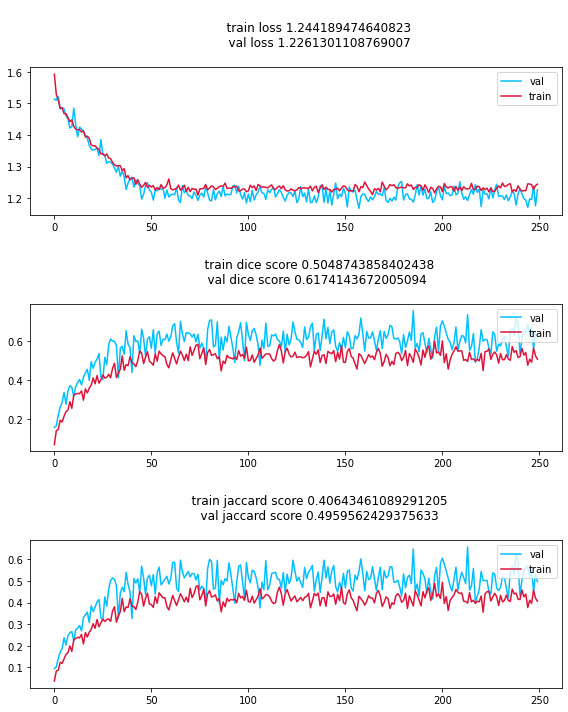

Saved check point


In [38]:
trainer.run()

In [39]:
def get_dataloader(dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4):
    """
    This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
    to split and transform image
    """
    start_time = time.time()
    data = pd.read_csv(path_to_csv)
    train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
    val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    for i in range(len(data_set)):
        list_subjects.append(data_set[i])
    subject_dataset = tio.SubjectsDataset(list_subjects, transform=get_transform(phase))
    data_loader = DataLoader(subject_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_memory=True,
                             shuffle=True, 
                            )
    return data_loader

In [40]:
dataloader = get_dataloader(dataset=BratsDataSet, path_to_csv=config.train_df, phase='valid', fold=0)
len(dataloader)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


34

In [41]:
data = next(iter(dataloader))
data['id'], data['image'][tio.DATA].shape, data['label'][tio.DATA].shape

(['BraTS20_Training_250'],
 torch.Size([1, 4, 78, 120, 120]),
 torch.Size([1, 3, 78, 120, 120]))

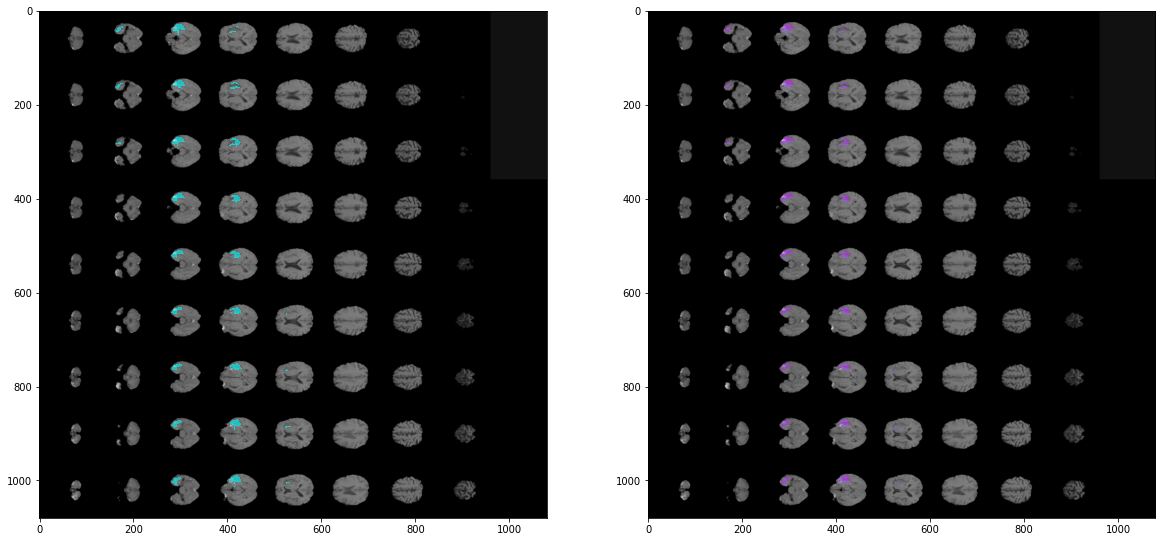

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    images = data['image'][tio.DATA].to(device)
    targets = data['label'][tio.DATA].to(device)
    predict = model(images)
    img_tensor = data['image'][tio.DATA].squeeze()[1].cpu().detach().numpy() 
    mask_tensor = data['label'][tio.DATA].squeeze()[0].squeeze().cpu().detach().numpy()
    predict_tensor = predict.squeeze()[0].squeeze().cpu().detach().numpy()
    image = np.rot90(montage(img_tensor))
    mask_predict = np.rot90(montage(predict_tensor))
    mask = np.rot90(montage(mask_tensor)) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
    ax1.imshow(image, cmap = 'gray')
    ax1.imshow(np.ma.masked_where(mask == False, mask),
    cmap='cool', alpha=0.6)
    ax2.imshow(image, cmap ='gray')
    ax2.imshow(np.ma.masked_where(mask == False, mask_predict),
    cmap='cool', alpha=0.6)

In [43]:
data = next(iter(dataloader))
data['id'], data['image'][tio.DATA].shape, data['label'][tio.DATA].shape

(['BraTS20_Training_042'],
 torch.Size([1, 4, 78, 120, 120]),
 torch.Size([1, 3, 78, 120, 120]))

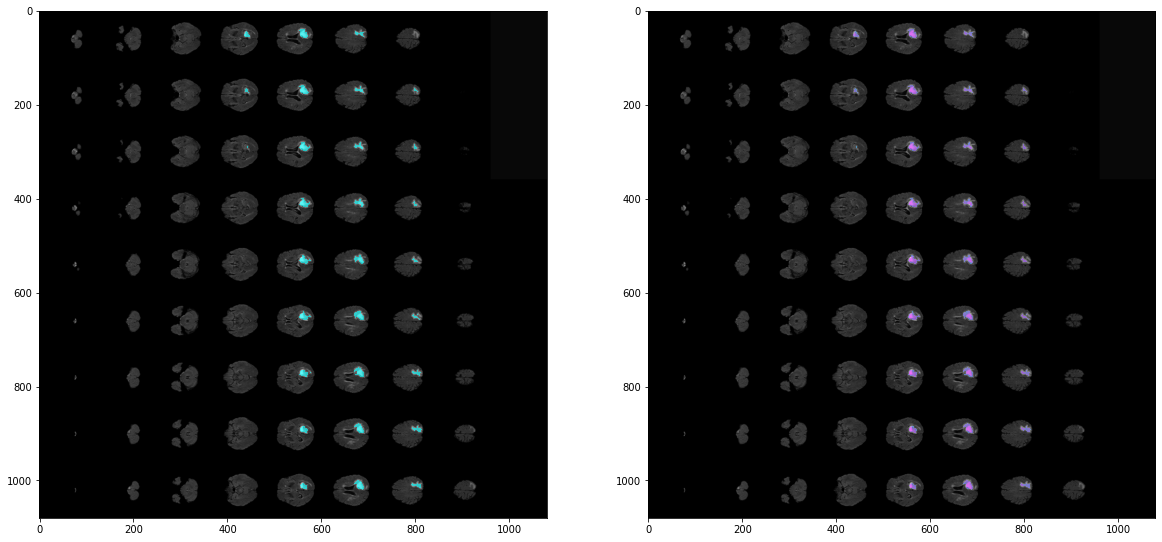

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    images = data['image'][tio.DATA].to(device)
    targets = data['label'][tio.DATA].to(device)
    predict = model(images)
    img_tensor = data['image'][tio.DATA].squeeze()[0].cpu().detach().numpy() 
    mask_tensor = data['label'][tio.DATA].squeeze()[0].squeeze().cpu().detach().numpy()
    predict_tensor = predict.squeeze()[0].squeeze().cpu().detach().numpy()
    image = np.rot90(montage(img_tensor))
    mask_predict = np.rot90(montage(predict_tensor))
    mask = np.rot90(montage(mask_tensor)) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
    ax1.imshow(image, cmap = 'gray')
    ax1.imshow(np.ma.masked_where(mask == False, mask),
    cmap='cool', alpha=0.6)
    ax2.imshow(image, cmap ='gray')
    ax2.imshow(np.ma.masked_where(mask == False, mask_predict),
    cmap='cool', alpha=0.6)

In [45]:
data = next(iter(dataloader))
data['id'], data['image'][tio.DATA].shape, data['label'][tio.DATA].shape

(['BraTS20_Training_008'],
 torch.Size([1, 4, 78, 120, 120]),
 torch.Size([1, 3, 78, 120, 120]))

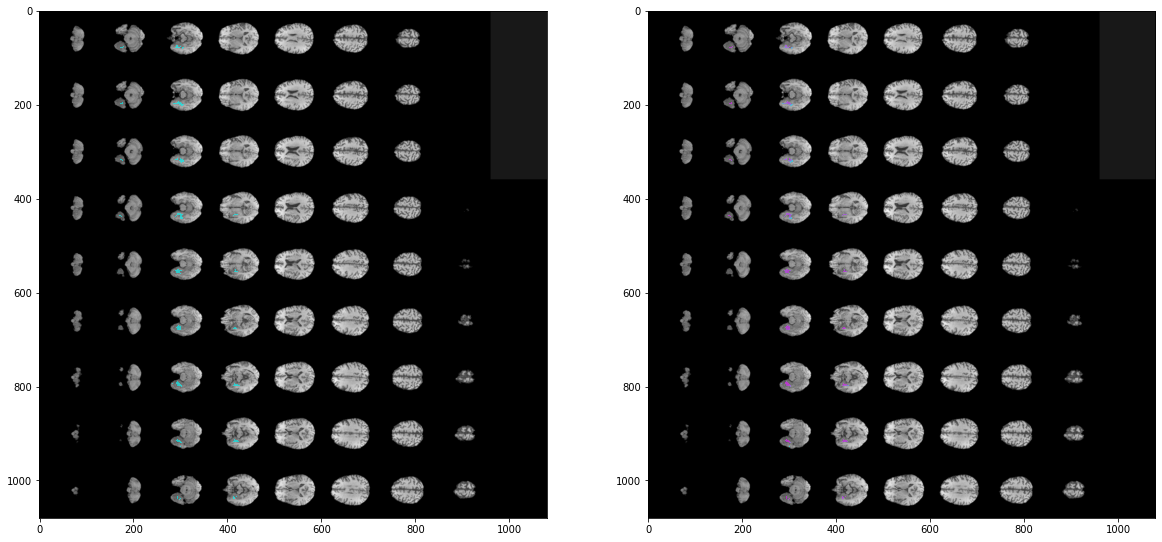

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    images = data['image'][tio.DATA].to(device)
    targets = data['label'][tio.DATA].to(device)
    predict = model(images)
    img_tensor = data['image'][tio.DATA].squeeze()[1].cpu().detach().numpy() 
    mask_tensor = data['label'][tio.DATA].squeeze()[0].squeeze().cpu().detach().numpy()
    predict_tensor = predict.squeeze()[0].squeeze().cpu().detach().numpy()
    image = np.rot90(montage(img_tensor))
    mask_predict = np.rot90(montage(predict_tensor))
    mask = np.rot90(montage(mask_tensor)) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
    ax1.imshow(image, cmap = 'gray')
    ax1.imshow(np.ma.masked_where(mask == False, mask),
    cmap='cool', alpha=0.6)
    ax2.imshow(image, cmap ='gray')
    ax2.imshow(np.ma.masked_where(mask == False, mask_predict),
    cmap='cool', alpha=0.6)